In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clone the repo, download the necessary files, etc.

In [2]:
%cd /content
!git clone https://github.com/leolani/cltl-face-all
!cd cltl-face-all/ && pip install .
!pip install omegaconf==2.0.5
!pip install tqdm av

# Download the annotations and stuff
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
!wget https://raw.githubusercontent.com/cltl/ma-communicative-robots/master/multimodal/dataset-small.json
!wget https://raw.githubusercontent.com/cltl/ma-communicative-robots/master/multimodal/dataset-medium.json
!wget https://raw.githubusercontent.com/cltl/ma-communicative-robots/master/multimodal/dataset-large.json

# !gdown --id 1U442a03S8D60ojqviwRTiZcwZ_phg6Aj
!gdown --id 1-2LeHC_5Cm2gWWT6vBrVhp8jorbjkN1_
!unzip visual-features.zip
!rm visual-features.zip

!gdown --id 16ck7plW9v9eSHGCs5wuB2AhhufPRt3Wi
!unzip smaller-dataset.zip
!rm smaller-dataset.zip

!ls smaller-dataset/  |  wc -l
!ls visual-features | wc -l

import os
from glob import glob
import csv
import json
import numpy as np

# Only the train_sent_emo is relevant to us since the smaller datasets
# are subset of the original train dataset.
annotation_path = 'train_sent_emo.csv'
        
VIDS_DIR = 'smaller-dataset/'

datasets_ = {}
datasets_['small'] = "dataset-small.json"
datasets_['medium'] = "dataset-medium.json"
datasets_['large'] = "dataset-large.json"

for datasize in ['small', 'medium', 'large']:
    with open(datasets_[datasize], 'r') as stream:
        datasets_[datasize] = json.load(stream)

with open(annotation_path) as f:
    reader = csv.reader(f)
    annotations = list(reader)


# See if we have all of the videos
for datasize in ['small', 'medium', 'large']:
    for datatype in ['train', 'dev', 'test']:
        diautt_ = datasets_[datasize][datatype]
        for diautt in diautt_:
            assert os.path.isfile(os.path.join(VIDS_DIR, diautt))

# Find the corresponding speaker / emotion / sentiment from the annotations

diautt2anno = {}
for row in annotations[1:]:
    SrNo, Utterance, Speaker, Emotion, Sentiment, Dialogue_ID,\
        Utterance_ID, Season, Episode, StartTime, EndTime = row

    if f"dia{Dialogue_ID}_utt{Utterance_ID}.mp4" not in str(os.listdir(os.path.join(VIDS_DIR))):
        continue
    
    diautt2anno[f"dia{Dialogue_ID}_utt{Utterance_ID}"] = \
        {'SrNo': SrNo, 
        'Utterance': Utterance, 
        'Speaker': Speaker, 
        'Emotion': Emotion, 
        'Sentiment': Sentiment, 
        'Dialogue_ID': Dialogue_ID,
        'Utterance_ID': Utterance_ID, 
        'Season': Season, 
        'Episode': Episode, 
        'StartTime': StartTime, 
        'EndTime':EndTime}


datasets = {}
for DATASIZE in ['small', 'medium', 'large']:
    datasets[DATASIZE] = {}
    for DATATYPE in ['train', 'dev', 'test']:
        datasets[DATASIZE][DATATYPE] = {}
        diautt_ = datasets_[DATASIZE][DATATYPE]
        for diautt in diautt_:
            diautt_without_mp4 = diautt.split('.mp4')[0]
            datasets[DATASIZE][DATATYPE][diautt_without_mp4] = diautt2anno[diautt_without_mp4]


visual_features = glob('visual-features/*.npy')
visual_features = {os.path.basename(vf).split('.npy')[0] : np.load(vf, allow_pickle=True).item() for vf in visual_features}

with open('datasets.json', 'w', encoding='utf8') as stream:
    json.dump(datasets, stream, ensure_ascii=False)

/content
Cloning into 'cltl-face-all'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 157 (delta 32), reused 134 (delta 13), pack-reused 0
Receiving objects: 100% (157/157), 20.01 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Processing /content/cltl-face-all
  Created wheel for cltl-face-all: filename=cltl_face_all-0.0.0-cp36-none-any.whl size=53234 sha256=3e6cda3a812a09562dd880b98ff5b69783e0f39cd53cd4eee37c8ecdc8d14a1e
  Stored in directory: /root/.cache/pip/wheels/8d/71/f3/2db0b17856a0b395aaa04c8562716e0350cfc712cdd4b9947e
Successfully built cltl-face-all
     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=eebc284ef8208874bfc231d6440fd883a2da36651df2555444d45a488b1ab919
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b2

# Load the data from storage to memory

The biggest difficulty is that the annotated face is not always in the video. It might be hidden. Let's try to match the annotated names with the face embeddings, if possible

## Let's start from the smallest

In [3]:
FACE_PROB = 0.975
EVERY_N_FRAME = 10
# SPEAKERS_OF_INTEREST = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']
DATASIZE_chosen = 'small'
DATASET_chosen = 'train'
dataset_chosen = datasets[DATASIZE_chosen][DATASET_chosen]

speakers_mentioned = []
embeddings_all = []

# This is gonna help us to find back to the source frame and video
idx2source = {}
embeddings_all = []
bboxes_all = []
landmarks_all = []

count = 0
for diautt, annot in dataset_chosen.items():
    # There is one face annotated in the entire video.
    # We are not even sure if the face is actually there or not.
    # Even though the face is there, we are not sure which frame number it is.

    # if annot['Speaker'] not in SPEAKERS_OF_INTEREST:
    #     continue

    for framenum, list_of_findings in visual_features[diautt].items():
        if framenum % EVERY_N_FRAME != 0:
            continue
        for finding in list_of_findings:
            if finding['bbox'][-1] < FACE_PROB:
                continue
            
            embeddings_all.append(finding['embedding'])
            bboxes_all.append(finding['bbox'])
            landmarks_all.append(finding['landmark'])
            idx2source[count] = {'diautt':diautt, 'frame': framenum}
            count+=1
            speakers_mentioned.append(annot['Speaker'])

assert len(embeddings_all) == len(bboxes_all) == len(landmarks_all) == \
        len(idx2source)

speakers_mentioned = sorted(list(set(speakers_mentioned)))

print(f"Out of the {len(dataset_chosen)} number of videos (utterances),")
print(f"There are in total of {len(speakers_mentioned)} unique speakers mentioned")
print()
print(speakers_mentioned)
print()
print(f"and {len(embeddings_all)} faces detected")

Out of the 173 number of videos (utterances),
There are in total of 16 unique speakers mentioned

['Ben', 'Chandler', 'Danny', 'Dr. Johnson', 'Dr. Rhodes', 'Joey', 'Leslie', 'Mischa', 'Monica', 'Phoebe', 'Rachel', 'Richard', 'Ross', 'The Assistant Director', 'The Director', 'Tom']

and 2751 faces detected


You can't just assume that every face detected is one of the 16 speakers mentioned, since there are also other faces in the scene. Let's try simple clustering of the embeddings. Refer to https://scikit-learn.org/stable/modules/clustering.html for data aclustering.

Clustering is not an easy topic. Our data are all unit vectors, which means that they are all located on the surface of a high-dimensional sphere. There must be exisitng work done here, which fits to our case. But I'll just copy and paste what I can easily find from scikit-learn.

In [7]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


X = np.stack(embeddings_all)

# #############################################################################
# Compute DBSCAN
# DBSCAN uses euclidean distance between the data points.
# TODO: find a way to replace it with angle distance.
# eps and min_samples are hyper parameters that you have to tune.
# At the moment 0.75 and 10, respectively, works decent.
db = DBSCAN(eps=0.75, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
print(f"Number of faces that are clustered: {len(embeddings_all) - n_noise_}")
print()

(label_num, counts) = np.unique(labels, return_counts=True)

for l, c in zip(label_num, counts):
    print(f" label {l} \t has {c} counts")

np.save('embeddings-clusters.npy', labels)
!cp 'embeddings-clusters.npy' drive/MyDrive/

Estimated number of clusters: 20
Estimated number of noise points: 1117
Silhouette Coefficient: 0.134
Number of faces that are clustered: 1634

 label -1 	 has 1117 counts
 label 0 	 has 115 counts
 label 1 	 has 199 counts
 label 2 	 has 283 counts
 label 3 	 has 256 counts
 label 4 	 has 18 counts
 label 5 	 has 18 counts
 label 6 	 has 272 counts
 label 7 	 has 38 counts
 label 8 	 has 42 counts
 label 9 	 has 17 counts
 label 10 	 has 129 counts
 label 11 	 has 24 counts
 label 12 	 has 22 counts
 label 13 	 has 35 counts
 label 14 	 has 61 counts
 label 15 	 has 24 counts
 label 16 	 has 20 counts
 label 17 	 has 28 counts
 label 18 	 has 23 counts
 label 19 	 has 10 counts


We got several clusters. This is not that many. We can go through one by one. The label `-1` is considered noise.


Below cell will save all of the images

In [21]:
import shutil
from tqdm.notebook import tqdm
import cv2
import av
import random
from cltl_face_all.face_alignment import FaceDetection

NUM_MAX_VID_PER_LABEL = 25

shutil.rmtree('faces', ignore_errors=True)

assert len(embeddings_all) == len(bboxes_all) == len(landmarks_all) == \
        len(idx2source) == len(labels)

VIDS_DIR = 'smaller-dataset/'


list_all = []


indices = list(idx2source.keys())
for idx in indices:
    label_ = labels[idx]

    embedding_ = embeddings_all[idx]
    bbox_ = bboxes_all[idx]
    landmark_ = landmarks_all[idx]
    source_ = idx2source[idx]

    to_append = {'label': label_, 
                'embedding': embedding_,
                 'bbox': bbox_,
                 'landmark': landmark_,
                 'diautt': source_['diautt'],
                 'frame': source_['frame']}

    list_all.append(to_append)


assert len(list_all) == len(labels)

random.shuffle(list_all)


fd = FaceDetection(device='cpu', face_detector='sfd')

labels_processed = {l: 0 for l in set(labels)}

for finding in tqdm(list_all):
    label_ = finding['label']
    embedding_ = finding['embedding']
    bbox_ = finding['bbox']
    landmark_ = finding['landmark']
    diautt_ = finding['diautt']
    frame_num = finding['frame']
    video_path = os.path.join(VIDS_DIR, diautt_) + '.mp4'

    os.makedirs(os.path.join('faces', str(label_)), exist_ok=True)

    # if labels_processed[label_] > NUM_MAX_VID_PER_LABEL:
    #     continue

    assert os.path.isfile(video_path)

    container = av.open(video_path)
    for frame in container.decode(video=0):
        idx = frame.index
        img = np.array(frame.to_image())

        if idx == frame_num:
            break

    batch = img[np.newaxis, ...]
    face = fd.crop_and_align(batch, [bbox_[np.newaxis, ...]], [landmark_[np.newaxis, ...]])
    face = np.squeeze(face)

    img_write_path = os.path.join('faces', 
                                  str(label_), 
                                  f"{diautt_}_frame{frame_num}_{'_'.join([str(foo) for foo in bbox_.astype(np.int).tolist()[:4]])}.jpg")

    cv2.imwrite(img_write_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
    labels_processed[label_] +=1


!zip -r faces.zip faces
!cp faces.zip drive/MyDrive/

/usr/local/lib/python3.6/dist-packages/cltl_face_all/face_alignment/matlab_cp2tform.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)



  adding: faces/ (stored 0%)
  adding: faces/2/ (stored 0%)
  adding: faces/2/dia151_utt7_frame70_705_120_872_352.jpg (deflated 3%)
  adding: faces/2/dia151_utt9_frame150_707_128_869_367.jpg (deflated 3%)
  adding: faces/2/dia151_utt9_frame20_709_139_872_369.jpg (deflated 3%)
  adding: faces/2/dia151_utt17_frame10_708_132_884_376.jpg (deflated 3%)
  adding: faces/2/dia151_utt15_frame10_731_149_900_372.jpg (deflated 3%)
  adding: faces/2/dia151_utt11_frame50_814_120_921_276.jpg (deflated 4%)
  adding: faces/2/dia124_utt1_frame0_3_73_244_340.jpg (deflated 5%)
  adding: faces/2/dia151_utt9_frame180_683_134_852_373.jpg (deflated 3%)
  adding: faces/2/dia124_utt11_frame160_198_156_334_348.jpg (deflated 3%)
  adding: faces/2/dia151_utt17_frame20_718_149_887_379.jpg (deflated 3%)
  adding: faces/2/dia270_utt0_frame100_516_73_625_222.jpg (deflated 4%)
  adding: faces/2/dia136_utt1_frame10_589_95_669_207.jpg (deflated 4%)
  adding: faces/2/dia1007_utt7_frame40_499_113_617_289.jpg (deflated 3%)

Now go through the faces if they match the names


['-1', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


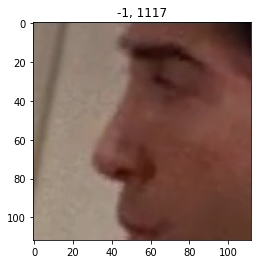

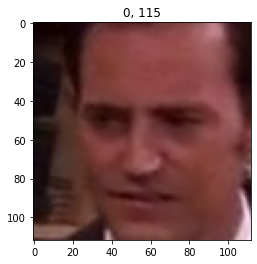

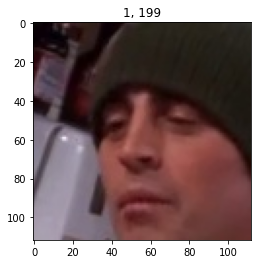

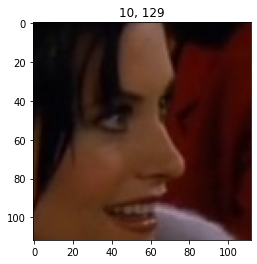

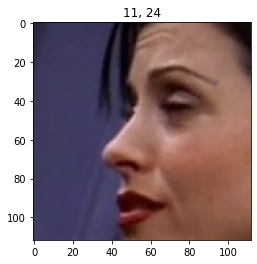

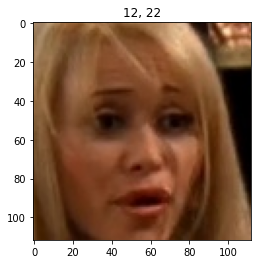

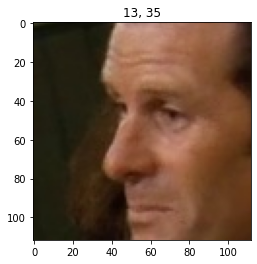

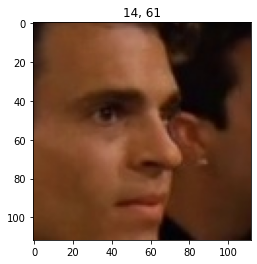

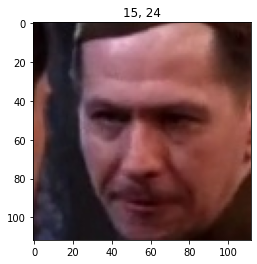

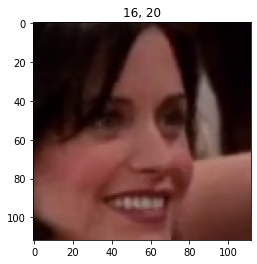

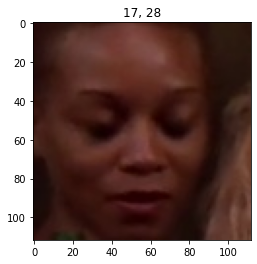

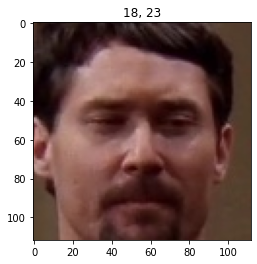

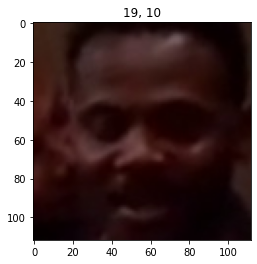

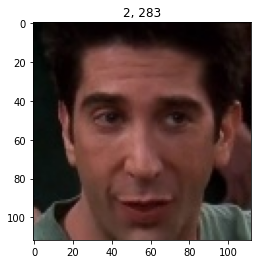

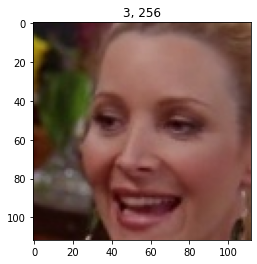

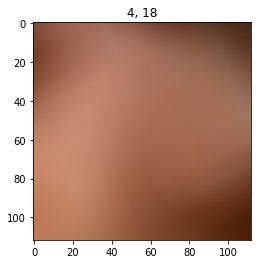

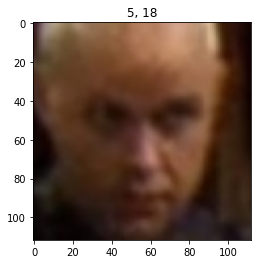

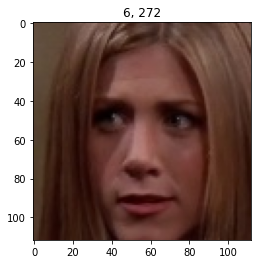

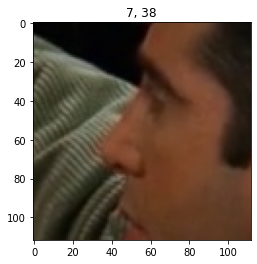

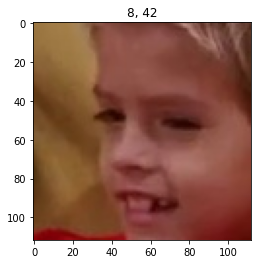

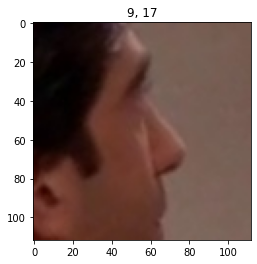

In [41]:
import matplotlib.pyplot as plt
from glob import glob
import random
import os
import cv2

print(sorted(os.listdir('faces/')))

for label in sorted(os.listdir('faces/')):
    images = glob(os.path.join('faces', label, '*.jpg'))
    img = random.choice(images)
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(img)
    plt.title(f"{label}, {len(images)}")


## Here are my findings

```
 label character   note
 -1  noise
 0   Chandler
 1   Joey
 2   Ross
 3   Phoebe
 4   noise
 5   Gunther
 6   Rachel
 7   Ross (side) remove it
 8   Ben
 9   Ross (side) remove it
 10  Monica
 11  Monica (side)   remove it
 12  Leslie
 13  a dude (side)   remove it
 14  a dude (side)   remove it
 15  Richard Gary Oldman
 16  Monica
 17  DONT KNOW
 18  Tom
 19  DONT KNOW
```
It was almost perfect that it clustered 2 front Monicas, not 1. From now on, we only keep the frontal face, which gives us

```
 0   Chandler
 1   Joey
 2   Ross
 3   Phoebe
 4   noise
 5   Gunther
 6   Rachel
 8   Ben
 10  Monica
 12  Leslie
 15  Richard
 16  Monica
 18  Tom
```

10 and 16 will be merged




In [23]:
to_keep = {'Chandler': [],
           'Joey': [],
           'Ross': [],
           'Phoebe': [],
           'Gunther': [],
           'Rachel': [],
           'Ben': [],
           'Monica': [],
           'Leslie': [],
           'Richard': [],
           'Tom': []}

label2name = {0: 'Chandler',
              1: 'Joey',
              2: 'Ross',
              3: 'Phoebe',
              5: 'Gunther',
              6: 'Rachel',
              8: 'Ben',
              10: 'Monica',
              12: 'Leslie',
              15: 'Richard',
              16: 'Monica',
              18: 'Tom'}

for finding in list_all:
    label_ = finding['label']
    embedding_ = finding['embedding']
    bbox_ = finding['bbox']
    landmark_ = finding['landmark']
    diautt_ = finding['diautt']
    frame_num = finding['frame']

    if label_ in list(label2name.keys()):
        to_keep[label2name[label_]].append(embedding_)

In [39]:
final_vectors = {}
for name, list_of_embs in to_keep.items():
    sum_of_vecs = np.sum(list_of_embs, axis=0)
    sum_of_vecs = sum_of_vecs / np.linalg.norm(sum_of_vecs)
    print(name, sum_of_vecs.shape, np.linalg.norm(sum_of_vecs), sum_of_vecs.dtype)
    final_vectors[name] = sum_of_vecs

np.save('friends-embeddings.npy', final_vectors)
!cp friends-embeddings.npy drive/MyDrive/

Chandler (512,) 0.99999994 float32
Joey (512,) 0.99999994 float32
Ross (512,) 0.99999994 float32
Phoebe (512,) 0.99999994 float32
Gunther (512,) 1.0 float32
Rachel (512,) 1.0 float32
Ben (512,) 1.0 float32
Monica (512,) 1.0 float32
Leslie (512,) 0.99999994 float32
Richard (512,) 0.99999994 float32
Tom (512,) 0.99999994 float32
